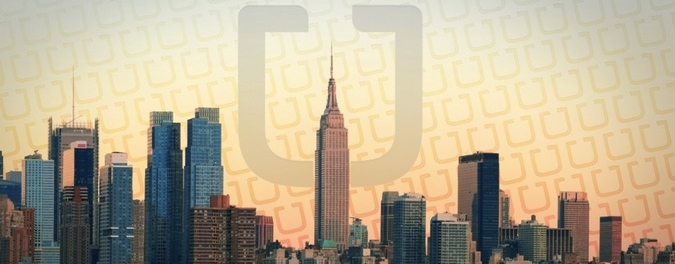

In [86]:
from IPython.display import Image
Image(filename='images/uber-new-york2.jpeg') 

# Uber Ride Prediction in New York

## Table of Contents

## Project Summary
---

**Siuation**  
The demand for rideshearing is drastically growing, especially in large cities. Uber is the first ride-hailing company and has operation in over 900 metropolitan areas worldwide. This project aims to investigate whether weather can make an impact on the demand for Uber rides in New York.  
  
**Action and  Goal**  
Using the Uber trip data (the mid-6 months of 2014 and the first 6 months of 2015) and the weather data, data exploration and model deployment are implemented by using Python and jupyter notebook. The goal is to build a predictive model and test the hypothesis that ***"Weather makes an impact on the demand for the uber rides in New York"***.

ARIMA: Auto Regressive Integrated Moving Average

## Assumptions
---
- Since all boroughs are neighboring the same weather information in NY was used.
- Since the available Uber trip data is for only 6 months of 2015, the result might have bias such as seasonal trend and anomary events.

## Comments(to be rivised)
In a more optimized version we may use more localized weather stations but the area is relatively narrow for significant weather differences.
Additionally, using information from different stations may enter noise by various factors (like missing values or small calibration differences).

---
# Loading 
---

## Import Libraries 
---

In [806]:
import sys, os
sys.path.append(os.pardir)
import math
import warnings
warnings.filterwarnings('ignore')

from datetime import date
from datetime import datetime

# EDA
import numpy as np
import pandas as pd
from functools import reduce


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from boruta import  BorutaPy 

## Functions 
---

In [5]:
def memory_usage(var, lower_limit=0):
    # input: var = dir()
    print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
    print(" ------------------------------------ ")
    for var_name in var:
        if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > lower_limit:
            print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))
    return

In [70]:
def data_profile(df):
    
    # Datatype
    df_dtype = pd.DataFrame(df.dtypes)
    
    # Null count
    df_null = pd.DataFrame(df.isnull().sum())
    # Null ratio (%)
    null_ratio = df.isnull().sum() / df.shape[0] * 100 #Percentage
    null_ratio = null_ratio.apply(lambda x: math.floor(x * 10**2) / 10**2) #rounding
    df_null_ratio = pd.DataFrame(null_ratio)
    
    # Non-null count
    df_notnull = pd.DataFrame(df.notnull().sum())
    
    # Unique value/Unique ratio(%)
    df_unique = {}
    df_unique_ratio = {}
    
    for column in df.columns:
        df_unique[column] = len(df[column].value_counts())
        df_unique_ratio[column] = len(df[column].value_counts()) / df.shape[0] *100 #Percentage
        
    df_unique = pd.DataFrame.from_dict(df_unique, orient='index')
    df_unique_ratio = pd.DataFrame.from_dict(df_unique_ratio, orient='index')
    df_unique_ratio = df_unique_ratio[0].apply(lambda x: math.floor(x * 10**2) / 10**2) #rounding
    
    # Create a new dataframe showing the data profile 
    df_profile = pd.concat([df_dtype, df_null, df_null_ratio, df_notnull, df_unique, df_unique_ratio], axis=1).reset_index()
    df_profile.columns = ['Column', 'Data type', 'Null count', 'Null ratio (%)', 'Non-null count', 'Distinct', 'Distinct (%)']
    
    num_dup = df.duplicated().sum()
    if num_dup > 0:
        print(str(num_dup) + 'rows are duplicated')
    else: print('No duplicated row')
    return df_profile

## Import data
---
All data used in this project is stored in "data" directory.  
  
**Uber trip data from 2014** (April - September)  
: separated by month, with detailed location information
- uber-raw-data-apr14.csv
- uber-raw-data-aug14.csv
- uber-raw-data-jul14.csv
- uber-raw-data-jun14.csv
- uber-raw-data-may14.csv
- uber-raw-data-sep14.csv
  
**Uber trip data from 2015** (January - June)
: with less fine-grained location information
- uber-raw-data-janjune-15.csv
  
**Weather data**  
- humidity.csv
- pressure.csv
- temperature.csv
- weather_description.csv
- wind_direction.csv
- wind_speed.csv
  
**(Data Source)**  
The data shown above can be obtained from:  
- Uber trip data: https://github.com/fivethirtyeight/uber-tlc-foil-response  
- Histroical weather in NY: https://www.kaggle.com/selfishgene/historical-hourly-weather-data?select=humidity.csv



In [6]:
# Uber data
uber_data_dir = 'data/uber-tlc-foil-response/uber-trip-data/uber-raw-data-'
# uber_raw_apr14 = pd.read_csv(uber_data_dir + 'apr14.csv')
# uber_raw_may14 = pd.read_csv(uber_data_dir + 'may14.csv')
# uber_raw_jun14 = pd.read_csv(uber_data_dir + 'jun14.csv')
# uber_raw_jul14 = pd.read_csv(uber_data_dir + 'jul14.csv')
# uber_raw_aug14 = pd.read_csv(uber_data_dir + 'aug14.csv')
# uber_raw_sep14 = pd.read_csv(uber_data_dir + 'sep14.csv')

# Concatenate raw data between April and September, 2014
# uber_raw_aprsep14 = pd.concat([uber_raw_apr14
#                              , uber_raw_may14
#                              , uber_raw_jun14
#                              , uber_raw_jul14
#                              , uber_raw_aug14
#                              , uber_raw_sep14]).reset_index()

# delete non-used variables
# del uber_raw_apr14, uber_raw_may14, uber_raw_jun14, uber_raw_jul14, uber_raw_aug14, uber_raw_sep14

# Raw data between January and June, 2015
uber_raw_janjun15 = pd.read_csv(uber_data_dir + 'janjune-15.csv').reset_index()
taxi_zone = pd.read_csv('data/uber-tlc-foil-response/uber-trip-data/taxi-zone-lookup.csv')

Base_code_ref = pd.DataFrame({
    'Base Code':['B02512', 'B02598', 'B02617', 'B02682', 'B02764', 'B02765', 'B02835', 'B02836'],
    'Base Name':['Unter', 'Hinter', 'Weiter', 'Schmecken', 'Danach-NY', 'Grun', 'Dreist', 'Drinnen']  
})

# Weather data
city_attrib = pd.read_csv('data/weather/city_attributes.csv')
humidity = pd.read_csv('data/weather/humidity.csv')
pressure = pd.read_csv('data/weather/pressure.csv')
temperature = pd.read_csv('data/weather/temperature.csv')
weather_description = pd.read_csv('data/weather/weather_description.csv')
wind_direction = pd.read_csv('data/weather/wind_direction.csv')
wind_speed = pd.read_csv('data/weather/wind_speed.csv')

In [7]:
# Check memory usage
# var = dir()
# memory_usage(var, lower_limit=1000)

|            Variable Name|    Memory|
 ------------------------------------ 
|            Base_code_ref|      1156|
|              city_attrib|      5549|
|                 humidity|  16472236|
|                 pressure|  16472236|
|                taxi_zone|     38683|
|              temperature|  16472236|
|        uber_raw_aprsep14| 732183857|
|        uber_raw_janjun15|3105936521|
|      weather_description| 115377955|
|           wind_direction|  16472236|
|               wind_speed|  16472236|


# Exploring the Data 

## Data Overview
---

### Input variables 
---
**Uber trip data from 2014**   
- Date/Time : The date and time of the Uber pickup
- Lat : The latitude of the Uber pickup
- Lon : The longitude of the Uber pickup
- Base : The TLC base company code affiliated with the Uber pickup
  
**Uber trip data from 2015**  
- Dispatching_base_num : The TLC base company code of the base that dispatched the Uber
- Pickup_date : The date and time of the Uber pickup
- Affiliated_base_num : The TLC base company code affiliated with the Uber pickup
- locationID : The pickup location ID affiliated with the Uber pickup

**Weather data**  
- datetime : The date and time of the weather record  
---

### Uber rides data 

In [8]:
uber_raw_aprsep14.shape

(4534327, 5)

In [9]:
uber_raw_janjun15.shape

(14270479, 5)

In [10]:
# Uber trip data from 2014
uber_raw_aprsep14.head()

,index,Date/Time,Lat,Lon,Base
0,0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [11]:
# Uber trip data from 2015
uber_raw_janjun15.head()

,index,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,0,B02617,2015-05-17 09:47:00,B02617,141
1,1,B02617,2015-05-17 09:47:00,B02617,65
2,2,B02617,2015-05-17 09:47:00,B02617,100
3,3,B02617,2015-05-17 09:47:00,B02774,80
4,4,B02617,2015-05-17 09:47:00,B02617,90


In [389]:
# Location reference
taxi_zone.head()

,LocationID,Borough,Zone
0,1,EWR,Newark Airport
1,2,Queens,Jamaica Bay
2,3,Bronx,Allerton/Pelham Gardens
3,4,Manhattan,Alphabet City
4,5,Staten Island,Arden Heights


In [307]:
# Borough
uber_raw_janjun15['borough'] = uber_raw_janjun15['locationID']\
                            .map(taxi_zone.set_index('LocationID')['Borough'])
uber_raw_janjun15['borough'].unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island',
       'Unknown', 'EWR'], dtype=object)

In [316]:
uber_raw_janjun15.head()

,index,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,datetime,datehour,borough
0,0,B02617,2015-05-17 09:47:00,B02617,141,2015-05-17 09:47:00,2015-05-17 09,Manhattan
1,1,B02617,2015-05-17 09:47:00,B02617,65,2015-05-17 09:47:00,2015-05-17 09,Brooklyn
2,2,B02617,2015-05-17 09:47:00,B02617,100,2015-05-17 09:47:00,2015-05-17 09,Manhattan
3,3,B02617,2015-05-17 09:47:00,B02774,80,2015-05-17 09:47:00,2015-05-17 09,Brooklyn
4,4,B02617,2015-05-17 09:47:00,B02617,90,2015-05-17 09:47:00,2015-05-17 09,Manhattan


#### Format date and time

In [310]:
# convert string to timestamp object
# uber_raw_aprsep14['datetime'] = pd.to_datetime(uber_raw_aprsep14['Date/Time'])
uber_raw_janjun15['datetime'] = pd.to_datetime(uber_raw_janjun15['Pickup_date'])

In [311]:
# extract date and time (hour)
uber_raw_janjun15['datehour'] = uber_raw_janjun15['datetime'].dt.strftime('%Y-%m-%d %H')

#### Time period of the uber trip data

In [312]:
# print('Uber trip data from 2014')
# print('Min date: %s' % uber_raw_aprsep14['datetime'].min())
# print('Max date: %s' % uber_raw_aprsep14['datetime'].max())

In [313]:
print('Uber trip data from 2015')
print('Min date: %s' % uber_raw_janjun15['datetime'].min())
print('Max date: %s' % uber_raw_janjun15['datetime'].max())

Uber trip data from 2015
Min date: 2015-01-01 00:00:05
Max date: 2015-06-30 23:59:00


In [314]:
data_profile(uber_raw_janjun15)

No duplicated row


,Column,Data type,Null count,Null ratio (%),Non-null count,Distinct,Distinct (%)
0,index,int64,0,0.00,14270479,14270479,100.00
1,Dispatching_base_num,object,0,0.00,14270479,8,0.00
2,Pickup_date,object,0,0.00,14270479,2744783,19.23
3,Affiliated_base_num,object,162195,1.13,14108284,284,0.00
4,locationID,int64,0,0.00,14270479,262,0.00
5,datetime,datetime64[ns],0,0.00,14270479,2744783,19.23
6,datehour,object,0,0.00,14270479,4334,0.03
7,borough,object,0,0.00,14270479,7,0.00


<div class='alert-success'>

- The uber trip data for 2015 has no duplicated data.  
- 1.1% of Affliated_base_num is NaN values.

</div>

---
### Weathre data 

#### Extract and concatenate the weather data for New York 

In [17]:
# Extract weather in NY and merge weather data

# merged weather data
dataframes = [
    humidity[['datetime','New York']]
    , pressure[['datetime','New York']]
    , temperature[['datetime','New York']]
    , weather_description[['datetime','New York']]
    , wind_direction[['datetime','New York']]
    , wind_speed[['datetime','New York']]
]

# merged data frame for weather data in NY
weather_NY = reduce(lambda left, right: pd.merge(left, right , on='datetime',
                   how='outer'), dataframes)

weather_NY.columns = ['datetime', 'humidity', 'pressure', 'temperature', 'weather_description', 'wind_direction', 'wind_speed']

# delete the unnecessary variables
del humidity, pressure, temperature, weather_description, wind_direction, wind_speed

In [59]:
# Weather data (01/01/2015 - 31/06/2015)
weather_NY_15 = weather_NY[weather_NY['datetime'] < '2015-07'][weather_NY['datetime'] > '2015']

In [315]:
# Check memory usage
# var = dir()
# memory_usage(var, lower_limit=1000)
# del var

#### Weather descriptions

In [19]:
weather_NY['weather_description'].unique()

array([nan, 'few clouds', 'sky is clear', 'scattered clouds',
       'broken clouds', 'overcast clouds', 'mist', 'drizzle',
       'moderate rain', 'light intensity drizzle', 'light rain', 'fog',
       'haze', 'heavy snow', 'heavy intensity drizzle',
       'heavy intensity rain', 'light rain and snow', 'snow',
       'light snow', 'freezing rain', 'proximity thunderstorm',
       'thunderstorm', 'thunderstorm with rain', 'smoke',
       'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'squalls', 'dust',
       'proximity thunderstorm with rain',
       'thunderstorm with light drizzle', 'sand', 'shower rain',
       'proximity thunderstorm with drizzle',
       'light intensity shower rain', 'sand/dust whirls',
       'heavy thunderstorm'], dtype=object)

#### Temperature 

In [21]:
#Convert temperature (K) into temperature (C: degree Celsius)
weather_NY['temperature'] = weather_NY['temperature'] - 273.15

#### Format date and time  

In [60]:
weather_NY_15['datetime'] = pd.to_datetime(weather_NY_15['datetime'])

In [64]:
# extract date and time (hour)
weather_NY_15['datehour'] = weather_NY_15['datetime'].dt.strftime('%Y-%m-%d %H')

In [68]:
print('Weather data (2015)')
print(weather_NY_15['datetime'].min())
print(weather_NY_15['datetime'].max())

Weather data (2015)
2015-01-01 00:00:00
2015-06-30 23:00:00


#### Basic summary of the weather data 

In [72]:
data_profile(weather_NY_15)

No duplicated row


,Column,Data type,Null count,Null ratio (%),Non-null count,Distinct,Distinct (%)
0,datetime,datetime64[ns],0,0.0,4344,4344,100.00
1,humidity,float64,0,0.0,4344,77,1.77
2,pressure,float64,0,0.0,4344,66,1.51
3,temperature,float64,0,0.0,4344,3081,70.92
4,weather_description,object,0,0.0,4344,19,0.43
5,wind_direction,float64,0,0.0,4344,354,8.14
6,wind_speed,float64,0,0.0,4344,11,0.25
7,datehour,object,0,0.0,4344,4344,100.00


<div class='alert-success'>

The weather data for the first 6 months in 2015 does not have missing data and duplicated data 

</div>

In [107]:
weather_state = weather_NY_15['weather_description'].unique()
print(weather_state)
print('\n The number of the weather states is', len(weather_state))

['sky is clear' 'few clouds' 'broken clouds' 'overcast clouds'
 'light rain' 'moderate rain' 'heavy intensity rain' 'light snow'
 'scattered clouds' 'snow' 'mist' 'haze' 'fog' 'very heavy rain'
 'light intensity drizzle' 'proximity thunderstorm'
 'thunderstorm with light rain' 'thunderstorm' 'drizzle']

 The number of the weather states is 19


## Data preparation for analysis

### Hourly demand for rides

In [338]:
# hourly rides from all borough
hourly_Uber_rides = uber_raw_janjun15[['datehour','datetime']]\
                    .groupby('datehour')\
                    .count()\
                    .reset_index()
hourly_Uber_rides.columns  = ['datehour', 'count']

In [339]:
hourly_Uber_rides.head()

,datehour,count
0,2015-01-01 00,6465
1,2015-01-01 01,6001
2,2015-01-01 02,7171
3,2015-01-01 03,5874
4,2015-01-01 04,3529


### Hourly demand for rides by borough

In [337]:
# hourly rides from all borough
hourly_rides_borough = uber_raw_janjun15[['datehour','datetime','borough']]\
                        .groupby(['datehour','borough'])\
                        .count()\
                        .reset_index()
hourly_rides_borough.columns  = ['datehour','borough', 'count']

In [332]:
hourly_rides_borough.head()

,datehour,borough,count
0,2015-01-01 00,Bronx,144
1,2015-01-01 00,Brooklyn,1371
2,2015-01-01 00,Manhattan,4567
3,2015-01-01 00,Queens,377
4,2015-01-01 00,Staten Island,3


### Merge Uber rides data and weather data

In [333]:
df_hourly_rides = pd.merge(hourly_Uber_rides, weather_NY_15, on='datehour')
df_hourly_rides_borough = pd.merge(hourly_rides_borough, weather_NY_15, on='datehour')

In [340]:
# add day of week(0:Sun, 1:Mon,...,6)
df_hourly_rides['day_of_week'] = df_hourly_rides['datetime'].dt.strftime('%w')
df_hourly_rides_borough['day_of_week'] = df_hourly_rides_borough['datetime'].dt.strftime('%w')

In [341]:
df_hourly_rides.head()

,datehour,count,datetime,humidity,pressure,temperature,weather_description,wind_direction,wind_speed,day_of_week
0,2015-01-01 00,6465,2015-01-01 00:00:00,59.0,1022.0,-5.100,sky is clear,249.0,2.0,4
1,2015-01-01 01,6001,2015-01-01 01:00:00,59.0,1022.0,-5.100,sky is clear,249.0,2.0,4
2,2015-01-01 02,7171,2015-01-01 02:00:00,58.0,1021.0,-5.964,sky is clear,246.0,2.0,4
3,2015-01-01 03,5874,2015-01-01 03:00:00,58.0,1021.0,-5.964,sky is clear,246.0,2.0,4
4,2015-01-01 04,3529,2015-01-01 04:00:00,58.0,1021.0,-5.964,sky is clear,246.0,2.0,4


<AxesSubplot:>

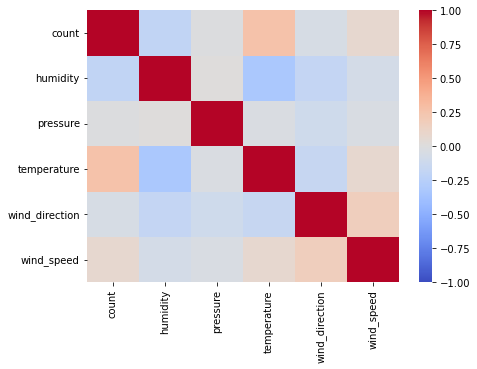

In [343]:
fig, ax = plt.subplots(figsize=(7,5))

sns.heatmap(df_hourly_rides.corr(), ax=ax,vmax=1, vmin=-1, cmap='coolwarm')

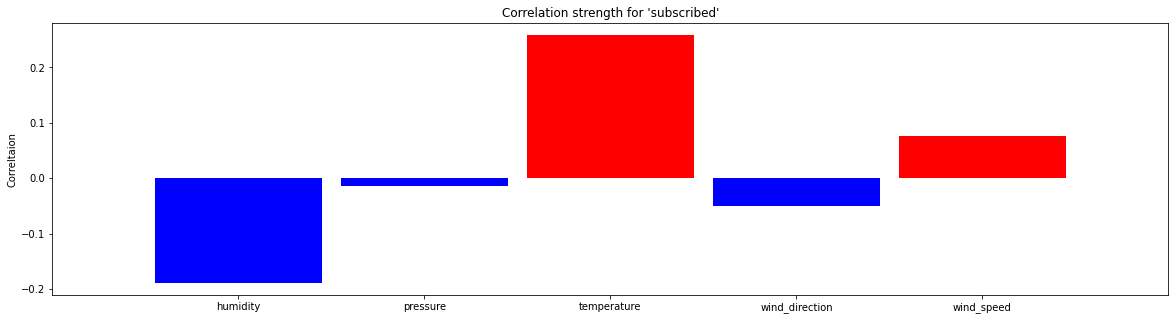

In [277]:
fig, ax = plt.subplots(figsize =(20,5))
corr_matt_sub = df.corr().drop('count', axis=0)

color_cor = []
for i in corr_matt_sub['count']:
    if i >= 0:
        color_cor.append('red')
    else:
        color_cor.append('blue')

plt.bar(x=corr_matt_sub['count'][:].index, height=corr_matt_sub['count'][:].values
        , color = color_cor, align='center', width=0.9)
# sns.barplot(x=corr_matt_sub['count'][:].index, y=corr_matt_sub['count'][:].values
#             , hue = color_cor)
# plt.xticks(rotation=90);
plt.xlim([-1, len(corr_matt_sub['count'][:].index)])
ax.set_ylabel('Correltaion');
ax.set_title("Correlation strength for 'subscribed'");
plt.show()

In [347]:
df_corr = df_hourly_rides_borough.copy()
df_corr = df_corr.drop(['datehour','datetime'], axis=1)

# sc = StandardScaler()
# df_corr['humidity'] = sc.fit_transform(df_corr[['humidity']])
# df_corr['temperature'] = sc.fit_transform(df_corr[['temperature']])
# df_corr['pressure'] = sc.fit_transform(df_corr[['pressure']])
# df_corr['wind_direction'] = sc.fit_transform(df_corr[['wind_direction']])
# df_corr['wind_speed'] = sc.fit_transform(df_corr[['wind_speed']])

df_corr = pd.get_dummies(df_corr)

df_corr.head()

,count,humidity,pressure,temperature,wind_direction,wind_speed,borough_Bronx,borough_Brooklyn,borough_EWR,borough_Manhattan,...,weather_description_thunderstorm,weather_description_thunderstorm with light rain,weather_description_very heavy rain,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,144,59.0,1022.0,-5.1,249.0,2.0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1371,59.0,1022.0,-5.1,249.0,2.0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,4567,59.0,1022.0,-5.1,249.0,2.0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,377,59.0,1022.0,-5.1,249.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3,59.0,1022.0,-5.1,249.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


<AxesSubplot:>

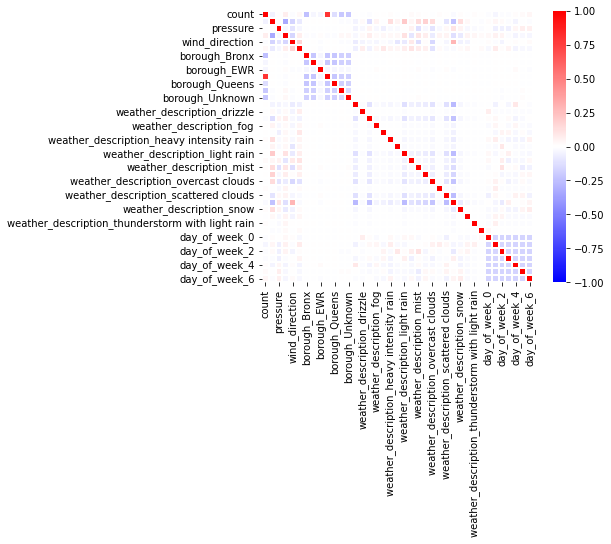

In [348]:
fig, ax = plt.subplots(figsize=(7,5))

sns.heatmap(df_corr.corr(),vmax=1, vmin=-1, cmap='bwr'
            , square=True, ax=ax, linewidths=0.1, center=0)

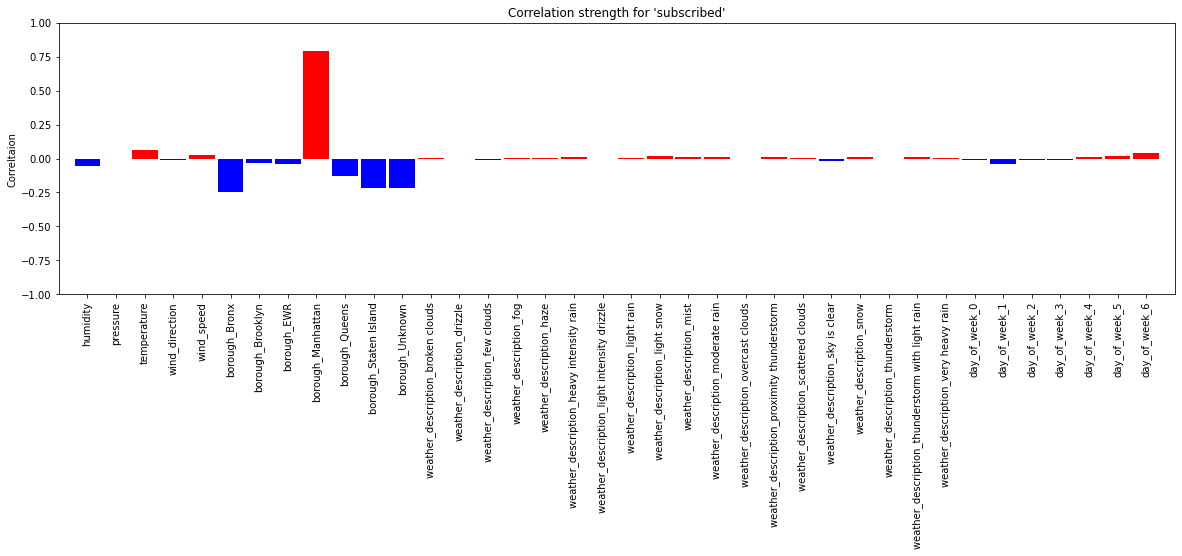

In [349]:
fig, ax = plt.subplots(figsize =(20,5))
corr_matt_sub = df_corr.corr().drop('count', axis=0)

color_cor = []
for i in corr_matt_sub['count']:
    if i >= 0:
        color_cor.append('red')
    else:
        color_cor.append('blue')

plt.bar(x=corr_matt_sub['count'][:].index, height=corr_matt_sub['count'][:].values
        , color = color_cor, align='center', width=0.9)
# sns.barplot(x=corr_matt_sub['count'][:].index, y=corr_matt_sub['count'][:].values
#             , hue = color_cor)
plt.xticks(rotation=90);
plt.xlim([-1, len(corr_matt_sub['count'][:].index)])
plt.ylim([-1, 1])
ax.set_ylabel('Correltaion');
ax.set_title("Correlation strength for 'subscribed'");
plt.show()

In [350]:
# Correlation 
corr_matt_sub['count'][:]

humidity                                           -0.051953
pressure                                           -0.005725
temperature                                         0.065102
wind_direction                                     -0.010699
wind_speed                                          0.025177
borough_Bronx                                      -0.246076
borough_Brooklyn                                   -0.031664
borough_EWR                                        -0.037221
borough_Manhattan                                   0.789427
borough_Queens                                     -0.131436
borough_Staten Island                              -0.217345
borough_Unknown                                    -0.215487
weather_description_broken clouds                   0.002328
weather_description_drizzle                        -0.003478
weather_description_few clouds                     -0.008952
weather_description_fog                             0.001106
weather_description_haze

## Visualization 

### The number of rides by borough 

<AxesSubplot:xlabel='borough', ylabel='count'>

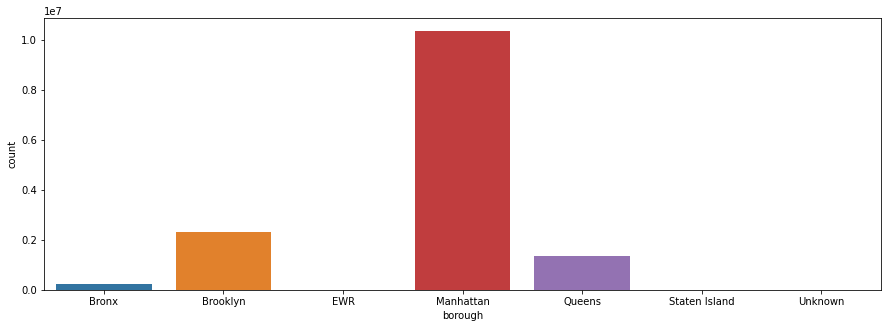

In [366]:
total_rides_by_borough = df_hourly_rides_borough.groupby('borough')['count'].agg(sum).reset_index()

total_rides_by_borough.columns = ['borough','count']
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x='borough', y = 'count', data = total_rides_by_borough)

<div class='alert-info'>

Manhattan has the most populous county followed by Brooklyn and Queens.  

</div>

### Average number of rides by event 

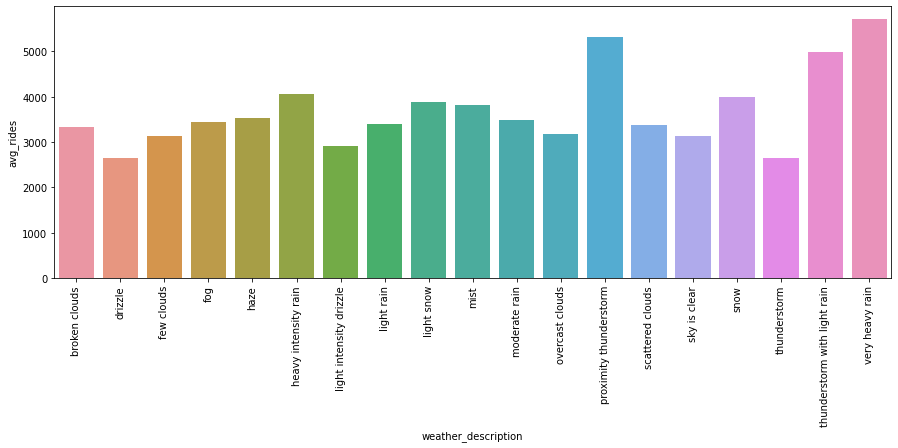

In [376]:
avg_rides_weather = df_hourly_rides.groupby('weather_description')['count'].mean().reset_index()
avg_rides_weather.columns = ['weather_description', 'avg_rides']

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x='weather_description', y = 'avg_rides', data = avg_rides_weather)
plt.xticks(rotation=90);

### Average Number of Rides by Event and Boroguh

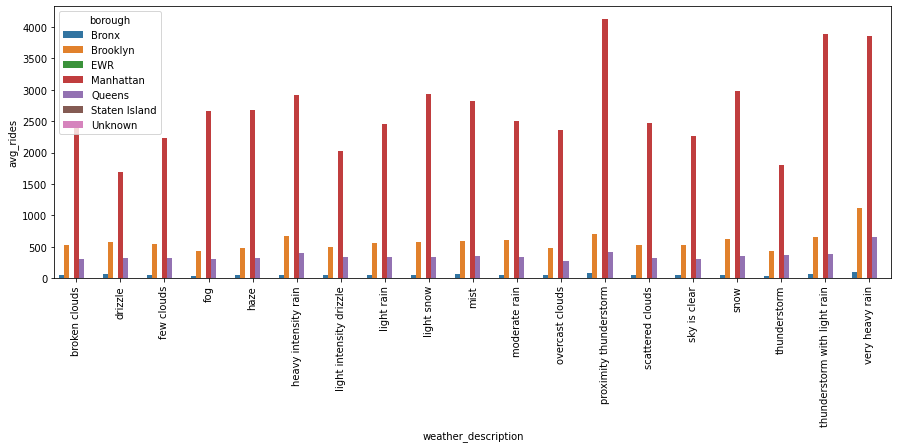

In [382]:
avg_rides_weather_borough = df_hourly_rides_borough.groupby(['weather_description','borough'])['count'].mean().reset_index()
avg_rides_weather_borough.columns = ['weather_description', 'borough', 'avg_rides']

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x='weather_description', y = 'avg_rides', hue = 'borough', data = avg_rides_weather_borough)
plt.xticks(rotation=90);

### Number of rides per hour by month

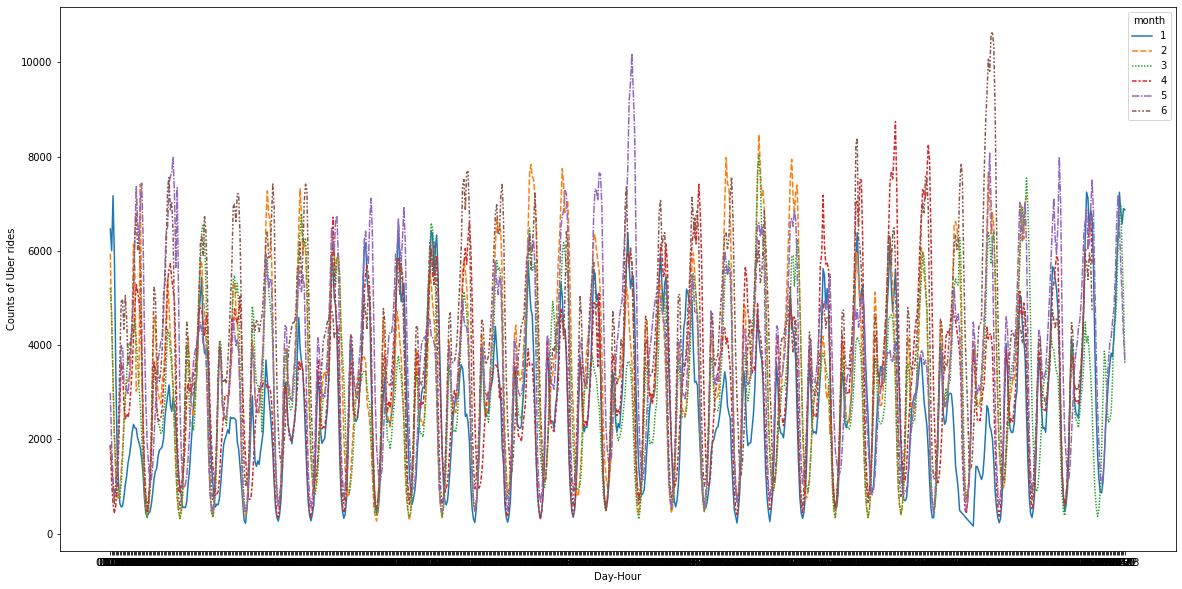

In [383]:
df_month = df.copy()
df_month['month'] = df_month['datetime'].dt.month
df_month['dayhour'] = df_month['datetime'].dt.strftime('%d %H')
df_month = df_month.pivot('dayhour','month','count')

fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data=df_month)
ax.set_ylabel('Counts of Uber rides');
ax.set_xlabel('Day-Hour');

### Histogram of the Uber rides by the weather decription 

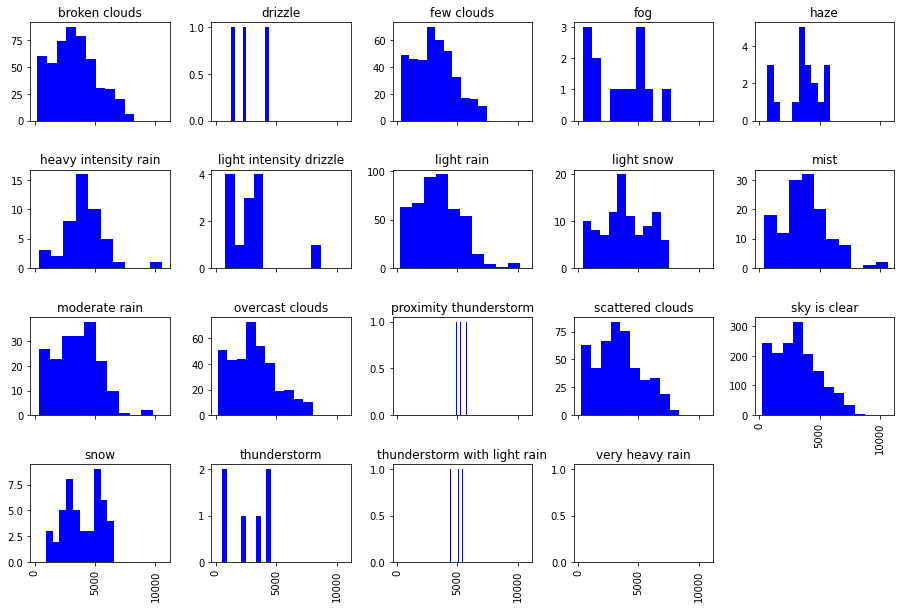

In [351]:
df_hourly_rides.hist(column="count", by='weather_description'
        , sharex=True, sharey=False
        , figsize=(15,10), layout=(4,5)
        , color='b'
       )
plt.show()

In [140]:
df.groupby('weather_description').count()['count']

weather_description
broken clouds                    496
drizzle                            3
few clouds                       399
fog                               13
haze                              19
heavy intensity rain              46
light intensity drizzle           13
light rain                       460
light snow                       102
mist                             133
moderate rain                    187
overcast clouds                  368
proximity thunderstorm             3
scattered clouds                 463
sky is clear                    1571
snow                              48
thunderstorm                       6
thunderstorm with light rain       3
very heavy rain                    1
Name: count, dtype: int64

<div class = 'alert-danger'>

- Some weather conditions (drizzle, fog, haze, heavy intensity rain, light intensity drizzle, proximity thunderstorm, snow, thunderstorm, thunderstorm with light rain, very heavy rain) are not frequent events (< 50 events)  
- The histogram is left-skewed

</div>

### Avrerage demand through the week

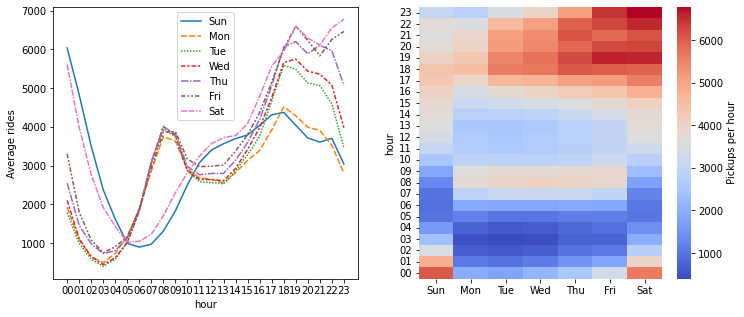

In [507]:
df_hour = df_hourly_rides[['datetime','datehour','day_of_week','count']]
df_hour['hour']=df['datetime'].dt.strftime('%H')

hourly_rides_day_mean = df_hour.groupby(['hour','day_of_week']).mean().unstack()
hourly_rides_day_mean.columns = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']

fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.lineplot(data=hourly_rides_day_mean, ax=axes[0])
axes[0].set_ylabel('Average rides')

sns.heatmap(hourly_rides_day_mean, ax=axes[1]
            , cmap='coolwarm', cbar_kws={'label':' Pickups per hour'})
axes[1].invert_yaxis()


### Distribution of demands per day 

In [536]:
df_rides_day = df_hourly_rides[['datetime','day_of_week','count']]
df_rides_day['date'] = df_rides_day['datetime'].dt.strftime('%Y-%m-%d')
daily_rides = df_rides_day.groupby(['date','day_of_week']).agg(sum).reset_index()
daily_rides.head()

,date,day_of_week,count
0,2015-01-01,4,58045
1,2015-01-02,5,40287
2,2015-01-03,6,59844
3,2015-01-04,0,41943
4,2015-01-05,1,43678


<AxesSubplot:xlabel='day_of_week', ylabel='count'>

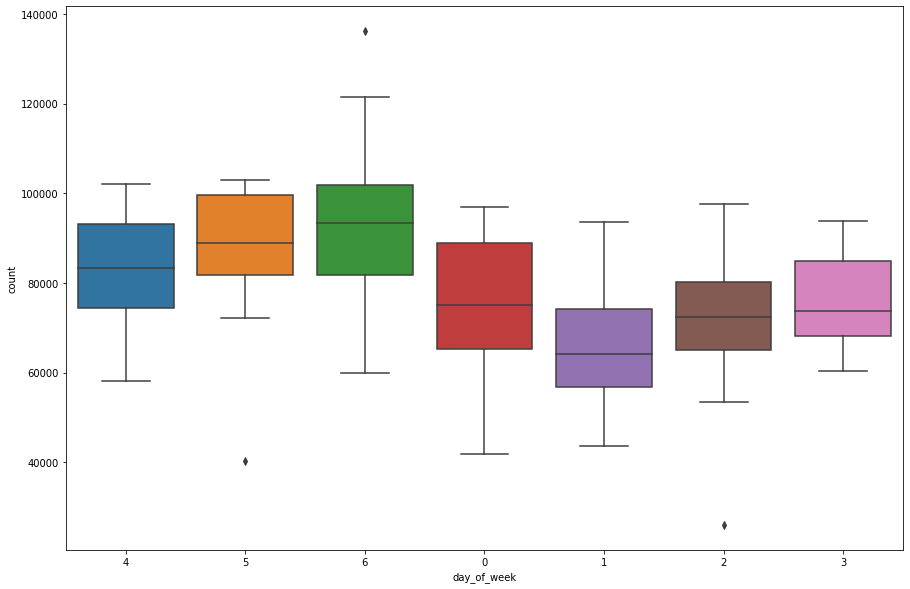

In [534]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='day_of_week', y='count', data=daily_rides)

### Average Demand through the week by Borough

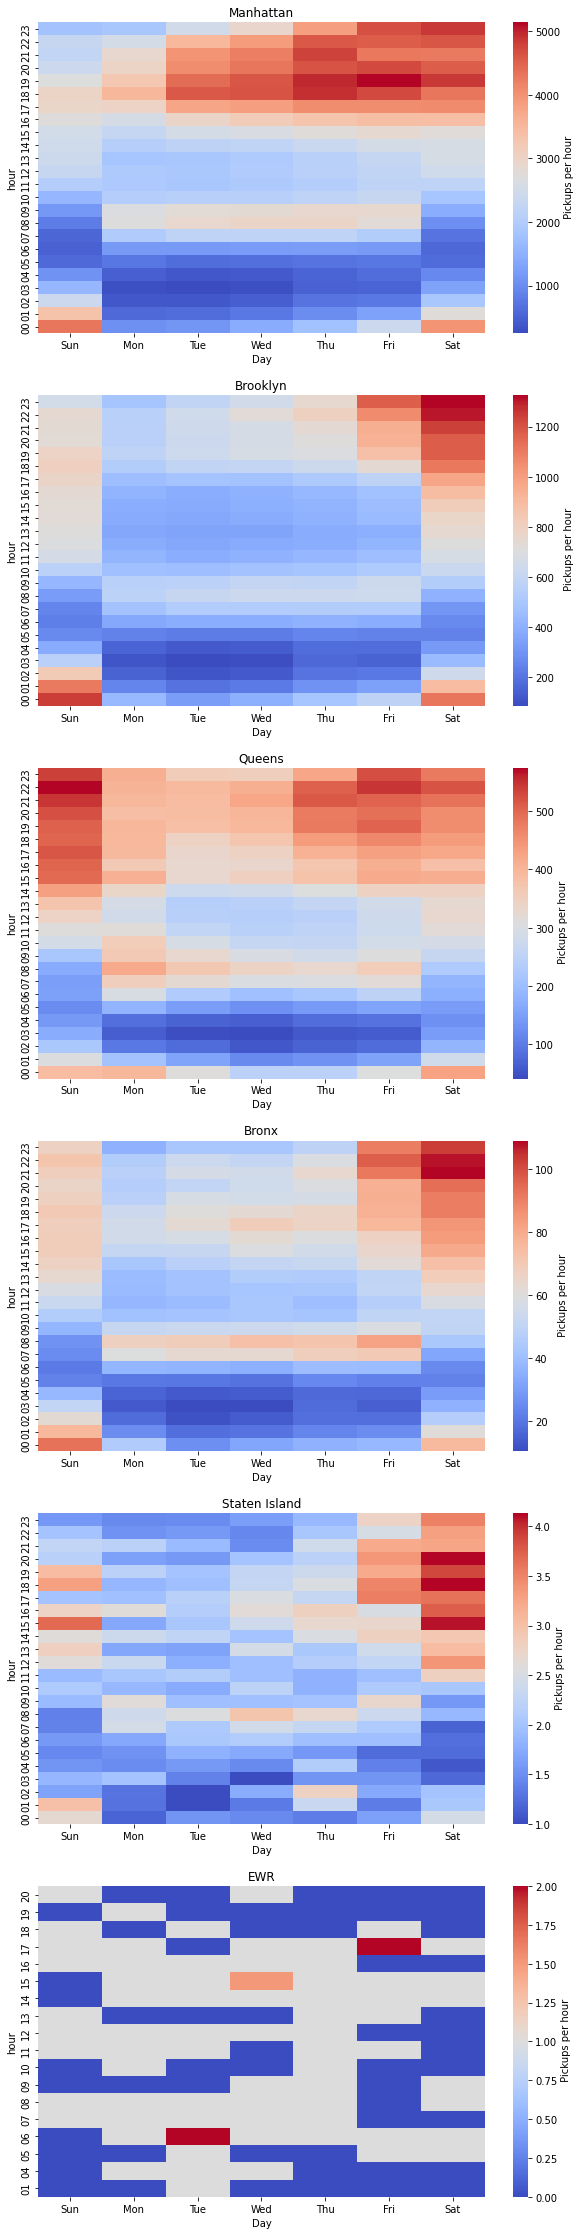

In [523]:
df_hour_borough = df_hourly_rides_borough[['datetime','datehour','day_of_week','count','borough']]
df_hour_borough['hour'] = df_hour_borough['datetime'].dt.strftime('%H')

list_borough = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island', 'EWR']
fig, axes = plt.subplots(6, 1, figsize=(10,40))

for borough, ax in zip(list_borough, axes):
    rides_borough = (
        df_hour_borough.loc[df_hour_borough['borough']==borough]
        .groupby(['hour','day_of_week']).mean().unstack()
    )
    rides_borough.columns = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
    rides_borough=rides_borough.fillna(0)
    sns.heatmap(rides_borough 
                ,ax=ax,cmap='coolwarm',cbar_kws={'label':' Pickups per hour'})
    ax.invert_yaxis()
    ax.set_title(borough);
    ax.set_xlabel('Day');

## Key findings from data explorartion
---
<div class='alert-info'>

- It seems that **time variables (time, day of week)** have much stronger effect on demand for the rides than **weather variables**.

</div>

## Feature Engineering

### Create Lag Features 
---
In time series data, at any point in time, the model needs information about the past. Here, to pass the past (most recent) information, lag feature is created.

In [556]:
df_hourly_rides.head()

,datehour,count,datetime,humidity,pressure,temperature,weather_description,wind_direction,wind_speed,day_of_week
0,2015-01-01 00,6465,2015-01-01 00:00:00,59.0,1022.0,-5.100,sky is clear,249.0,2.0,4
1,2015-01-01 01,6001,2015-01-01 01:00:00,59.0,1022.0,-5.100,sky is clear,249.0,2.0,4
2,2015-01-01 02,7171,2015-01-01 02:00:00,58.0,1021.0,-5.964,sky is clear,246.0,2.0,4
3,2015-01-01 03,5874,2015-01-01 03:00:00,58.0,1021.0,-5.964,sky is clear,246.0,2.0,4
4,2015-01-01 04,3529,2015-01-01 04:00:00,58.0,1021.0,-5.964,sky is clear,246.0,2.0,4


In [598]:
df_hour_borough

,datetime,datehour,day_of_week,count,borough,hour
0,2015-01-01 00:00:00,2015-01-01 00,4,144,Bronx,00
1,2015-01-01 00:00:00,2015-01-01 00,4,1371,Brooklyn,00
2,2015-01-01 00:00:00,2015-01-01 00,4,4567,Manhattan,00
3,2015-01-01 00:00:00,2015-01-01 00,4,377,Queens,00
4,2015-01-01 00:00:00,2015-01-01 00,4,3,Staten Island,00
...,...,...,...,...,...,...
23490,2015-06-30 23:00:00,2015-06-30 23,2,915,Brooklyn,23
23491,2015-06-30 23:00:00,2015-06-30 23,2,3166,Manhattan,23
23492,2015-06-30 23:00:00,2015-06-30 23,2,576,Queens,23
23493,2015-06-30 23:00:00,2015-06-30 23,2,1,Staten Island,23


In [686]:
df_model_rides = df_hourly_rides.copy()
# df_model_rides['day_of_week'] = df_model_rides['datetime'].dt.strftime('%a') 
df_model_rides = df_model_rides.drop(['datehour','day_of_week'], axis=1)
df_model_rides['time_block_num'] = df_model_rides.index+1

# Standardize the variables
sc = StandardScaler()
df_model_rides['humidity'] = sc.fit_transform(df_model_rides[['humidity']])
df_model_rides['temperature'] = sc.fit_transform(df_model_rides[['temperature']])
df_model_rides['pressure'] = sc.fit_transform(df_model_rides[['pressure']])
df_model_rides['wind_direction'] = sc.fit_transform(df_model_rides[['wind_direction']])
df_model_rides['wind_speed'] = sc.fit_transform(df_model_rides[['wind_speed']])
df_model_rides['day_of_week'] = df_model_rides['datetime'].dt.strftime('%a')
# Get one-hot label data for weather description 
df_model_rides = pd.get_dummies(df_model_rides)



borough_list_model = ['Manhattan', 'Brooklyn', 'Queens']

df_borough_model = df_hour_borough[['datetime', 'count', 'borough']]
for borough in borough_list_model:
    df_borough = df_borough_model.loc[df_borough_model['borough']==borough]
    df_borough=df_borough.drop(['borough'], axis=1)
    df_borough.columns = ['datetime']+['rides_'+borough]
    df_model_rides = pd.merge(df_model_rides, df_borough, on='datetime', how='left')

df_model_rides.columns

Index(['count', 'datetime', 'humidity', 'pressure', 'temperature',
       'wind_direction', 'wind_speed', 'time_block_num',
       'weather_description_broken clouds', 'weather_description_drizzle',
       'weather_description_few clouds', 'weather_description_fog',
       'weather_description_haze', 'weather_description_heavy intensity rain',
       'weather_description_light intensity drizzle',
       'weather_description_light rain', 'weather_description_light snow',
       'weather_description_mist', 'weather_description_moderate rain',
       'weather_description_overcast clouds',
       'weather_description_proximity thunderstorm',
       'weather_description_scattered clouds',
       'weather_description_sky is clear', 'weather_description_snow',
       'weather_description_thunderstorm',
       'weather_description_thunderstorm with light rain',
       'weather_description_very heavy rain', 'day_of_week_Fri',
       'day_of_week_Mon', 'day_of_week_Sat', 'day_of_week_Sun',
     

In [809]:
lag_variables = ['count'
                 , 'rides_Manhattan', 'rides_Brooklyn', 'rides_Queens'
       ,'humidity', 'pressure', 'temperature',
       'wind_direction', 'wind_speed', 'weather_description_broken clouds',
       'weather_description_drizzle', 'weather_description_few clouds',
       'weather_description_fog', 'weather_description_haze',
       'weather_description_heavy intensity rain',
       'weather_description_light intensity drizzle',
       'weather_description_light rain', 'weather_description_light snow',
       'weather_description_mist', 'weather_description_moderate rain',
       'weather_description_overcast clouds',
       'weather_description_proximity thunderstorm',
       'weather_description_scattered clouds',
       'weather_description_sky is clear', 'weather_description_snow',
       'weather_description_thunderstorm',
       'weather_description_thunderstorm with light rain',
       'weather_description_very heavy rain',
       'day_of_week_Fri',
       'day_of_week_Mon', 'day_of_week_Sat', 'day_of_week_Sun',
       'day_of_week_Thu', 'day_of_week_Tue', 'day_of_week_Wed']

# lags (1hr, 2hr, 3hr, 6hr, 12hr, 1day, 1week)
lags = [1, 2, 3, 6, 12, 24, 168]

In [810]:
df_model = df_model_rides.copy()

for lag in lags:
    
    df_lag = df_model.copy()
    df_lag.time_block_num+=lag
    # subset only the lag variable required
    df_lag = df_lag[['time_block_num']+lag_variables]
    df_lag.columns = ['time_block_num']+[lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    
    df_model = pd.merge(df_model, df_lag, on=['time_block_num'], how='left')
    
df_model = df_model.drop(range(0,168)).reset_index()
df_model = df_model.drop(['index'], axis=1)

In [811]:
df_model

,count,datetime,humidity,pressure,temperature,wind_direction,wind_speed,time_block_num,weather_description_broken clouds,weather_description_drizzle,...,weather_description_thunderstorm_lag_168,weather_description_thunderstorm with light rain_lag_168,weather_description_very heavy rain_lag_168,day_of_week_Fri_lag_168,day_of_week_Mon_lag_168,day_of_week_Sat_lag_168,day_of_week_Sun_lag_168,day_of_week_Thu_lag_168,day_of_week_Tue_lag_168,day_of_week_Wed_lag_168
0,1654,2015-01-08 00:00:00,-1.604268,-0.840260,-1.399546,-2.154214,-0.333756,169,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,838,2015-01-08 01:00:00,-1.604268,-0.649606,-1.529463,-2.238825,-0.333756,170,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,482,2015-01-08 02:00:00,-1.491482,-0.554279,-1.580366,1.462924,0.381625,171,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,325,2015-01-08 03:00:00,-1.378695,-0.554279,-1.614302,1.039867,1.812387,172,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,412,2015-01-08 04:00:00,-1.322302,-0.554279,-1.639753,1.462924,-0.333756,173,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161,5807,2015-06-30 19:00:00,-1.209515,-0.935588,1.726637,-0.705243,1.812387,4330,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4162,5392,2015-06-30 20:00:00,-1.040335,-0.935588,1.668947,-0.387950,1.097006,4331,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4163,5955,2015-06-30 21:00:00,-1.209515,-0.935588,1.632467,-0.493715,0.381625,4332,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4164,5749,2015-06-30 22:00:00,-0.645582,-1.030915,1.551022,-0.705243,1.812387,4333,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Modelling

In [812]:
time_block = df_model[['datetime', 'time_block_num']]

df_model = df_model.drop('datetime', axis=1)

X_train = df_model[df_model['time_block_num'] < 3663]
X_test = df_model[df_model['time_block_num'] >= 3663]

Y_train = X_train['count']
Y_test = X_test['count']

del X_train['count'],X_train['rides_Manhattan'], X_train['rides_Brooklyn'], X_train['rides_Queens']
del X_test['count'], X_test['rides_Manhattan'], X_test['rides_Brooklyn'], X_test['rides_Queens']

In [813]:
model = XGBRegressor(
    max_depth=20,
    n_estimators=1000,
#     min_child_weight=300, 
#     colsample_bytree=0.8, 
#     subsample=0.8, 
#     eta=0.3,    
    seed=42)

In [814]:
model.fit(
    X_train, 
    Y_train, 
    eval_set=[(X_train, Y_train), (X_test, Y_test)], 
    verbose=True
#     early_stopping_rounds = 10
)

[0]	validation_0-rmse:2608.18115	validation_1-rmse:3140.16724
[1]	validation_0-rmse:1852.36816	validation_1-rmse:2266.87891
[2]	validation_0-rmse:1323.08227	validation_1-rmse:1661.51501
[3]	validation_0-rmse:952.83905	validation_1-rmse:1288.41419
[4]	validation_0-rmse:692.88019	validation_1-rmse:1024.20996
[5]	validation_0-rmse:508.87082	validation_1-rmse:854.56244
[6]	validation_0-rmse:377.02533	validation_1-rmse:723.63776
[7]	validation_0-rmse:281.88776	validation_1-rmse:657.90485
[8]	validation_0-rmse:212.44720	validation_1-rmse:596.47815
[9]	validation_0-rmse:161.07201	validation_1-rmse:567.06531
[10]	validation_0-rmse:123.20768	validation_1-rmse:549.28522
[11]	validation_0-rmse:95.12734	validation_1-rmse:530.15216
[12]	validation_0-rmse:73.69916	validation_1-rmse:518.73157
[13]	validation_0-rmse:57.79583	validation_1-rmse:513.07245
[14]	validation_0-rmse:45.52547	validation_1-rmse:509.15540
[15]	validation_0-rmse:36.06758	validation_1-rmse:505.39676
[16]	validation_0-rmse:28.70992

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

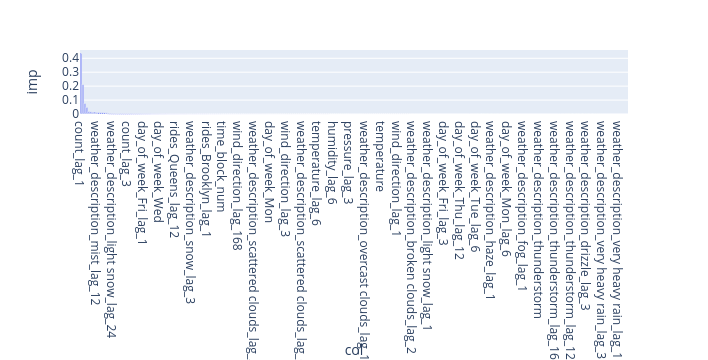

In [815]:
feature_importances = pd.DataFrame({'col': X_train.columns,'imp':model.feature_importances_})
feature_importances = feature_importances.sort_values(by='imp',ascending=False)
px.bar(feature_importances,x='col',y='imp')

In [816]:
Y_predict = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_predict)
rmse = np.sqrt(mse)
rmse

494.23789398735187

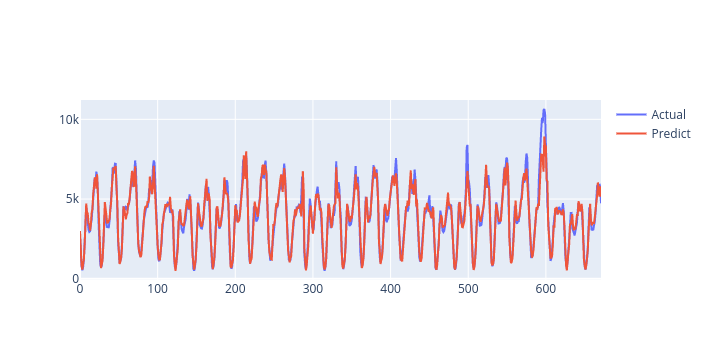

In [817]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=yyy['count'],
                    mode='lines',
                    name='Actual'))
fig.add_trace(go.Scatter(y=Y_predict,
                    mode='lines',
                    name='Predict'))

## Model Optimization

In [818]:
feature_selector =BorutaPy(model, 
                         n_estimators='auto', 
                         verbose=2, # 0: no output,1: displays iteration number,2: which features have been selected already
                         alpha=0.1,
                         max_iter=100,
                         random_state=42
                        )
feature_selector.fit(X_train.values, Y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	277
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	277
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	277
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	277
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	277
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	254
Iteration: 	7 / 100
Confirmed: 	6
Tentative: 	17
Rejected: 	254
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	17
Rejected: 	254
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	17
Rejected: 	254
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	17
Rejected: 	254
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	14
Rejected: 	256
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	14
Rejected: 	256
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	14
Rejected: 	256
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	14
Rejected: 	256
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	13
Rejected: 	257
Iteration: 	16 / 100
Confirmed: 	7
Tent

BorutaPy(alpha=0.1,
         estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, gamma=0, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints='',
                                learning_rate=0.300000012, max_delta_step=0,
                                max_depth=20, min_child_weight=1, missing=nan,
                                monotone_constraints='()', n_estimators=30,
                                n_jobs=8, num_parallel_tree=1,
                                random_state=451885870, reg_alpha=0,
                                reg_lambda=1, scale_pos_weight=1, seed=42,
                                subsample=1, tree_method='exact',
                                validate_parameters=1, verbosity=None),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 

In [819]:
X_train_selected.columns

Index(['day_of_week_Sun', 'count_lag_1', 'count_lag_2', 'count_lag_3',
       'count_lag_6', 'count_lag_12', 'day_of_week_Sun_lag_12', 'count_lag_24',
       'count_lag_168'],
      dtype='object')

In [820]:
X_train_selected = X_train.iloc[:,feature_selector.support_]
X_train_selected
X_test_selected = X_test.iloc[:,feature_selector.support_]

In [821]:
model.fit(
    X_train_selected, 
    Y_train, 
#     eval_set=[(X_train_selected, Y_train), (X_test_selected, Y_test)], 
    verbose=True
#     early_stopping_rounds = 10
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=30, n_jobs=8, num_parallel_tree=1,
             random_state=77883573, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

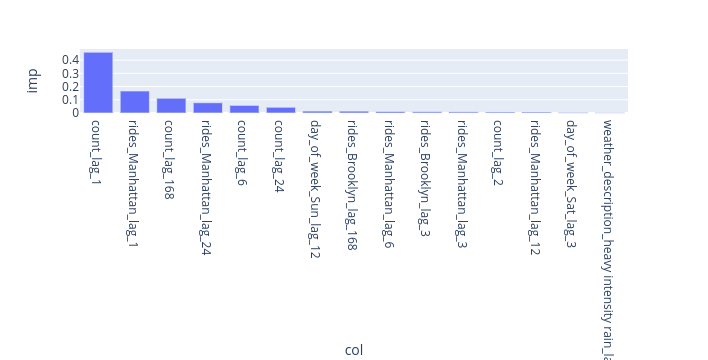

In [822]:
feature_importances = pd.DataFrame({'col': X_train_selected.columns,'imp':model.feature_importances_})
feature_importances = feature_importances.sort_values(by='imp',ascending=False)
px.bar(feature_importances,x='col',y='imp')

In [823]:
Y_predict = model.predict(X_test_selected)

In [824]:
mse = mean_squared_error(Y_test, Y_predict)
rmse = np.sqrt(mse)
rmse

445.89020832871915

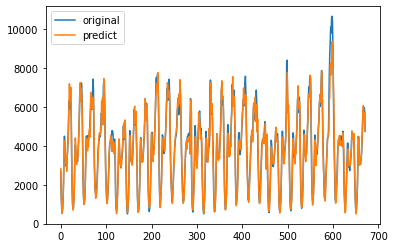

In [825]:
yyy = Y_test.reset_index()
plt.plot(yyy['count'], label='original')
plt.plot(Y_predict, label='predict')
plt.legend()


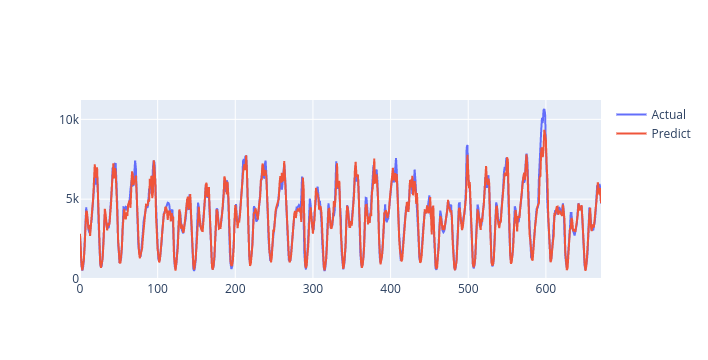

In [826]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=yyy['count'],
                    mode='lines',
                    name='Actual'))
fig.add_trace(go.Scatter(y=Y_predict,
                    mode='lines',
                    name='Predict'))